# Simulations for Random World article

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import matplotlib
import copy
from randworld import *

from sklearn.utils import resample

In [2]:
colorTableau = ["tab:blue", "tab:green", "tab:orange", "tab:red", "tab:purple", 
                "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]

## All simulations have the same backbone; an agent (Rat object) interacting with its environment (BoxWorld object). The agent can, at any time, either press or perform non-work actions. When a simulation starts (ie. the rat is placed in the box), the rat will output a random action, and the box will provide it with a new stateVector and reward. The rat then learns through these interactions


# Agent
### RL agent uses differential SARSA to use the average reward definition of an RPE (see p.249 of intro to RL book); this is not semi-gradient as long as the agent is used in tabular form (p.200 for details of semi-gradient methods). The average reward definition of RPE was used because it makes more sense for continuing tasks. Agent uses softmax action selection (p.322 for details) to allow intermediate levels of pressing and unifying exploration with action selection. Epsilon-greedy action selection is also used to avoid saturation of actions. The agent is capable of linear function approximation, but state vectors are 0's with a single 1, leading the agent to tabular RL instead.

# FIGURE 2d
### The main goal of this simulation is to show that if phasic DA is an RPE, then stable intermediate pressing behavior is not possible. The rat can either use the reward normally or use as an RPE, as determined by the "stimIsRPE variable". Since we are interested in the development of the pressing behavior within single trials, the rat and the box are refreshed upon every trial. Using the full triadic trial paradigm to show this would be counterproductive as the rat would reach maximal pressing behavior in the first trial (in the stimulation=RPE case), so averaging across trials would not show the growth in pressing behavior. 


In [12]:
stimIsRPE = True  #Does dopamine stimulation equate an RPE
trials = 250
t=BoxWorld_basic.trialLength

strengths = [1,4,10]  #give strengths of opto stim by trial type

actionList = np.zeros([len(strengths),trials,t])  #to record all actions
actions = ["rest","sniff","groom","press"]

rpes = np.zeros([3,trials,t])
rews = np.zeros([3,trials,t])  

for strengthIdx, strength in enumerate(strengths):
    for trialIdx in range(trials):
        box = BoxWorld_basic(stimIsRPE, strength)
        qvals = np.zeros([4,1])
        rat = Rat(box.state, qvals, 0.1, 0.1)
        for timeIdx in range(t):
            if timeIdx == 0:
                rat.update(0,box.state,False)
            else:
                rat.update(reward,state,rwdIsRPE)  
            reward, state, rwdIsRPE = box.getNextState(rat.action) 
            actionList[strengthIdx,trialIdx,timeIdx] = rat.action
        rpes[strengthIdx,trialIdx,1:] = rat.rpes
        rews[strengthIdx,trialIdx,1:] = rat.rews

Text(0.5, 1.0, 'Simulation: DA = Reward')

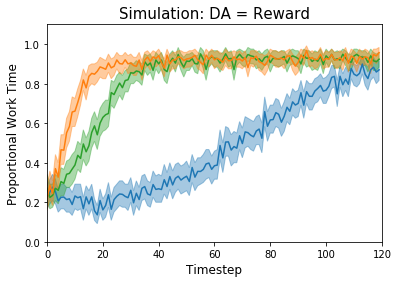

In [13]:
acts= (actionList==3)  

n_resamps = 1000
resamp_mean = np.zeros([acts.shape[0], acts.shape[-1], n_resamps])

fig, ax = plt.subplots()
vertices = np.zeros([acts.shape[-1]*2,2])
vertices[:acts.shape[-1],0] = np.arange(acts.shape[-1])
vertices[acts.shape[-1]:,0] = np.arange(acts.shape[-1]-1,-1,-1)

patches = []
for strgth in range(acts.shape[0]):
    for t in range(acts.shape[-1]):
        for ii in range(n_resamps):
            resamp = resample(acts[strgth,:,t], n_samples=acts.shape[-1])
#             resamp_mean[strgth,t,ii] = resamp.mean()
            resamp_mean[strgth,t,ii] = np.nanmean(resamp)
    
#     plt.plot(resamp_mean[strgth,:,:].mean(axis=1),color = colorTableau[strgth])
    plt.plot(np.nanmean(resamp_mean[strgth,:,:],axis=1),color = colorTableau[strgth])
    vertices[:acts.shape[-1],1] = np.percentile(resamp_mean[strgth,:,:],5,axis=1)
    vertices[acts.shape[-1]:,1] = np.flip(np.percentile(resamp_mean[strgth,:,:],95,axis=1))
    patches.append(copy.copy(vertices))
    
for ii,patch in enumerate(patches):
    path = matplotlib.path.Path(patch)
    lll = matplotlib.patches.PathPatch(path, alpha = 0.4, edgecolor = colorTableau[ii], facecolor = colorTableau[ii]) 
    ax.add_patch(lll)
    
plt.ylim((0,1.1))
plt.xlim((0,BoxWorld_basic.trialLength))
plt.xlabel('Timestep', fontsize = 12)
plt.ylabel('Proportional Work Time', fontsize = 12)
plt.title('Simulation: DA = Reward', fontsize = 15)

# FIGURE 2 c +
# FIGURE 3 a,c : Complete state information
### This simulation assumes that whatever information the rats use, it is used to perfectly allow it to parse out where it is in the task. This necessarily means that the state vector includes information about previous states. To designate this perfect parsing out of situations, we can give the rats 6 possible states: 1- the rat is in test trial and hasn't sample the lever yet 2-3-4-rat is in test trial with knowledge of low,med,hi stimulation strength  5-in leading trial, 6-in trailing trial.
### This moves away from the formal definition of a model, but encompasses the idea that the rat learns to integrate past information in state representation, which is close to our intuitive definition of a model.

In [14]:
stimIsRPE = False
numTriples = 150
triadsPerTriple = 3
trialsPerTriad = 3
trialLength = BoxWorld_complete.trialLength
t = trialLength*trialsPerTriad*triadsPerTriple*numTriples

actionList = np.zeros([t])
actions = ["sniff","explore","groom","press"]

strengths = [1,4,10]  #give 3 strengths

box = BoxWorld_complete(stimIsRPE, strengths)
qvals = np.zeros([4,6])
rat = Rat(box.state, qvals, 0.1, 0.01)
for timeIdx in range(t):
    if timeIdx == 0:
        rat.update(0,box.state,False)
    else:
        rat.update(reward,state,rwdIsRPE)  
    reward, state, rwdIsRPE = box.getNextState(rat.action) 
    actionList[timeIdx] = rat.action


Text(0.5, 1.0, 'Simulation: DA = Reward')

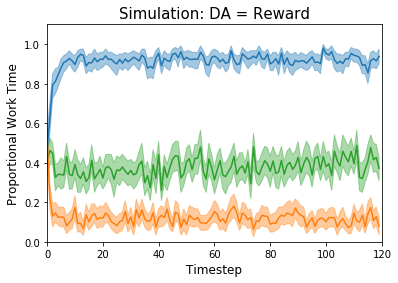

In [15]:
acts= np.reshape((actionList==3),[numTriples,triadsPerTriple,trialsPerTriad,trialLength])
acts = np.swapaxes(acts[:,:,1,:],0,1)
n_resamps = 100
resamp_mean = np.zeros([acts.shape[0], acts.shape[-1], n_resamps])

fig, ax = plt.subplots()
vertices = np.zeros([acts.shape[-1]*2,2])
vertices[:acts.shape[-1],0] = np.arange(acts.shape[-1])
vertices[acts.shape[-1]:,0] = np.arange(acts.shape[-1]-1,-1,-1)

patches = []
for strgth in range(acts.shape[0]):
    for t in range(acts.shape[-1]):
        for ii in range(n_resamps):
            resamp = resample(acts[strgth,:,t], n_samples=acts.shape[-1])
            resamp_mean[strgth,t,ii] = resamp.mean()
    
    plt.plot(resamp_mean[strgth,:,:].mean(axis=1),color = colorTableau[strgth])
    vertices[:acts.shape[-1],1] = np.percentile(resamp_mean[strgth,:,:],5,axis=1)
    vertices[acts.shape[-1]:,1] = np.flip(np.percentile(resamp_mean[strgth,:,:],95,axis=1))
    patches.append(copy.copy(vertices))
    
for ii,patch in enumerate(patches):
    path = matplotlib.path.Path(patch)
    lll = matplotlib.patches.PathPatch(path, alpha = 0.4, edgecolor = colorTableau[ii], facecolor = colorTableau[ii]) 
    ax.add_patch(lll)
    
plt.ylim((0,1.1))
plt.xlim((0,BoxWorld_complete.trialLength))
plt.xlabel('Timestep', fontsize = 12)
plt.ylabel('Proportional Work Time', fontsize = 12)
plt.title('Simulation: DA = Reward', fontsize = 15)

### The following graph shows that within one session, the latencies until first press are different across lead, test, and trailing trials, which indicates that the rat was able to learn a "model", or to use the information at its disposal properly

In [16]:
color = plt.cm.rainbow(np.linspace(1, 0.1, 3))
color[0,0]=0.5
color[1,:3]=[0.4,0.9,0.1]
color[-1,:2]=color[-1,:2]/2
color[-1,:3]=color[-1,:3]/1.5

Text(0.5, 1.0, 'Simulation: CDF of first press latencies')

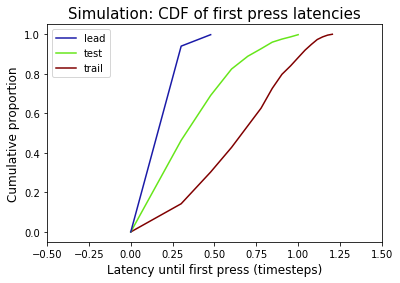

In [17]:
acts= np.reshape((actionList==3),[numTriples,triadsPerTriple,trialsPerTriad,trialLength])
firstPresses = getFirst10(acts)

data_sorted1 = np.reshape(firstPresses[:,:,:,0],[numTriples*3,3])
data_sorted2 = np.sort(data_sorted1,axis=0)
# calculate the proportional values of samples
p = 1. * np.arange(len(data_sorted1[:,0])) / (len(data_sorted1[:,0]) - 1)
uns = [np.unique(data_sorted2[:,ii],return_index=True) for ii in range(3)]
ps = [p[uns[ii][1]] for ii in range(3)]
ds = [uns[ii][0] for ii in range(3)]

trail, =plt.plot(np.log10(ds[0]),ps[0], color=color[0], label='trail')
test, =plt.plot(np.log10(ds[1]),ps[1], color=color[1], label='test')
lead, =plt.plot(np.log10(ds[2]),ps[2], color=color[2], label='lead')

plt.legend(handles=[lead,test,trail])
plt.xlabel('Latency until first press (timesteps)', fontsize = 12)
plt.xlim([-0.5,1.5])
plt.ylabel('Cumulative proportion', fontsize = 12)
plt.title('Simulation: CDF of first press latencies', fontsize = 15)

### The following graph shows that the latencies between presses may change more abruptly than in the simple state representation.

In [18]:
color = plt.cm.rainbow(np.linspace(1, 0.1, 10))
color[0,0]=0.5
color[-1,2]=0.5

Text(0.5, 1.0, 'Simulation: CDF of latencies between presses')

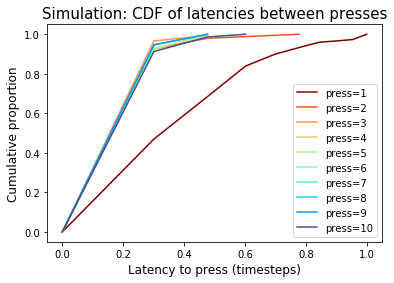

In [19]:
data_sorted2 = np.sort(firstPresses[:,0,1,:],axis=0)
p = 1. * np.arange(numTriples) / (numTriples - 1)
uns = [np.unique(data_sorted2[:,ii],return_index=True) for ii in range(10)]
ps = [p[uns[ii][1]] for ii in range(10)]
ds = [uns[ii][0] for ii in range(10)]

plts = []
for ii in range(10):
    plt.plot(np.log10(ds[ii]),ps[ii], color=color[ii],label='press='+str(ii+1))
plt.legend()
plt.xlabel('Latency to press (timesteps)', fontsize = 12)
plt.ylabel('Cumulative proportion', fontsize = 12)
plt.title('Simulation: CDF of latencies between presses', fontsize = 15)

# FIGURE 3e,g: Incomplete State Information

In [20]:
stimIsRPE = False
numTriples = 150  #triples are 3 triads: one for each test strength
triadsPerTriple = 3
trialsPerTriad = 3
trialLength = BoxWorld_incomplete.trialLength
t = trialLength*trialsPerTriad*triadsPerTriple*numTriples

actionList = np.zeros([t])
actions = ["sniff","explore","groom","press"]

strengths = [10,4,1]  #give 3 strengths

box = BoxWorld_incomplete(stimIsRPE, strengths)
qvals = np.zeros([4,3])
rat = Rat(box.state, qvals, 0.1, 0.01)
for timeIdx in range(t):
    if timeIdx == 0:
        rat.update(0,box.state,False)
    else:
        rat.update(reward,state,rwdIsRPE)  
    reward, state, rwdIsRPE = box.getNextState(rat.action) 
    actionList[timeIdx] = rat.action


In [21]:
color = plt.cm.rainbow(np.linspace(1, 0.1, 3))
color[0,0]=0.5
color[1,:3]=[0.4,0.9,0.1]
color[-1,:2]=color[-1,:2]/2
color[-1,:3]=color[-1,:3]/1.5

(-0.5, 2.5)

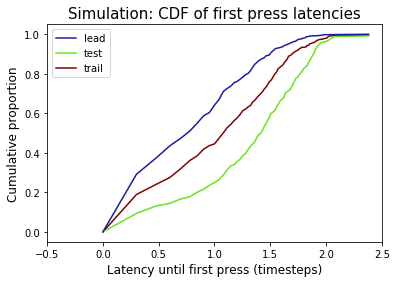

In [22]:
acts= np.reshape((actionList==3),[numTriples,triadsPerTriple,trialsPerTriad,trialLength])
firstPresses = getFirst10(acts)

data_sorted1 = np.reshape(firstPresses[:,:,:,0],[numTriples*3,3])
data_sorted2 = np.sort(data_sorted1,axis=0)
# calculate the proportional values of samples
p = 1. * np.arange(len(data_sorted1[:,0])) / (len(data_sorted1[:,0]) - 1)
uns = [np.unique(data_sorted2[:,ii],return_index=True) for ii in range(3)]
ps = [p[uns[ii][1]] for ii in range(3)]
ds = [uns[ii][0] for ii in range(3)]

un,ind = np.unique(np.log10(data_sorted2[:,2]), return_index=True)
trail, =plt.plot(un,p[ind], color=color[0], label='trail')
un,ind = np.unique(np.log10(data_sorted2[:,1]), return_index=True)
test, =plt.plot(un,p[ind], color=color[1], label='test')
un,ind = np.unique(np.log10(data_sorted2[:,0]), return_index=True)
lead, =plt.plot(un,p[ind], color=color[2], label='lead')

plt.legend(handles=[lead,test,trail])
plt.xlabel('Latency until first press (timesteps)', fontsize = 12)
plt.ylabel('Cumulative proportion', fontsize = 12)
plt.title('Simulation: CDF of first press latencies', fontsize = 15)
plt.xlim([-0.5,2.5])

In [23]:
color = plt.cm.rainbow(np.linspace(1, 0.1, 10))
color[0,0]=0.5
color[-1,2]=0.5

/home/francis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/francis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/francis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/francis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/francis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/francis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/francis/anaconda3/lib/python3.7/site-packages/

Text(0.5, 1.0, 'Simulation: CDF of latencies between presses')

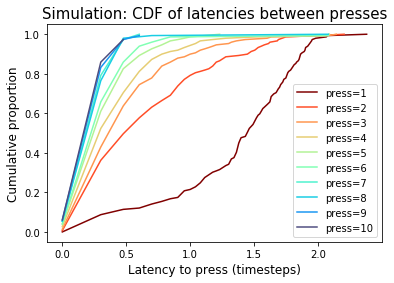

In [24]:
data_sorted2 = np.sort(firstPresses[:,0,1,:],axis=0)
# calculate the proportional values of samples
p = 1. * np.arange(len(data_sorted2[:,0])) / (len(data_sorted2[:,0]) - 1)
uns = [np.unique(data_sorted2[:,ii],return_index=True) for ii in range(10)]
ps = [p[uns[ii][1]] for ii in range(10)]
ds = [uns[ii][0] for ii in range(10)]

for ii in range(10):
    un,ind = np.unique(np.log10(data_sorted2[:,ii]), return_index=True)
    plt.plot(un,p[ind], color=color[ii], label='press='+str(ii+1))
    
plt.legend()
plt.xlabel('Latency to press (timesteps)', fontsize = 12)
plt.ylabel('Cumulative proportion', fontsize = 12)
plt.title('Simulation: CDF of latencies between presses', fontsize = 15)